<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [8]</a>'.</span>

# The Cookbook of Neural ODEs

Torchdyn implements out-of-the-box a variety of continuous-depth models. In this introductory tutorial, we show how we can switch between model variants with minor effort. We will touch upon the following Neural ODE variants:

* **Vanilla** (depth-invariant) (same as the [torchdyn quickstart](./00_quickstart.html) tutorial)
* **Vanilla** (depth-variant)
* **Galerkin**
* **Data-controlled**
* **Stacked (piece-wise constant weights)**
* **Stacked with discrete state transitions**
--------------------------------------

For more advanced models check out 

* [Hamiltonian Neural Networks](./06a_hamiltonian_nn.html)
* [Lagrangian Neural Networks](./06b_lagrangian_nn.html)
* [Continuous Normalizing Flow](./07_continuous_normalizing_flow.html)
* [Graph Neural ODEs](./08_graph_neural_de.html)

In [1]:
import sys ; sys.path.append('../')
from torchdyn.core import NeuralODE
from torchdyn.nn import DataControl, DepthCat, Augmenter
from torchdyn.datasets import *

**Data:** we use again the moons dataset (with some added noise) simply because all the models will be effective to solve this easy binary classification problem.



In [2]:
d = ToyDataset()
X, yn = d.generate(n_samples=512, dataset_type='moons', noise=.1)

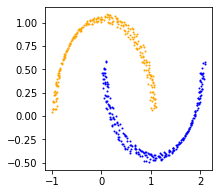

In [3]:
import matplotlib.pyplot as plt

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], s=1, color=colors[yn[i].int()])

In [4]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=True)

**Learner**

In [5]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model(x)   
        loss = nn.CrossEntropyLoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.005)

    def train_dataloader(self):
        return trainloader

**Note:** In this notebook we will consider the depth domain $[0,1]$, i.e. $s\in[0,1]$. Note that, for most architectures in *static* settings (aka we do not deal with dynamic data) any other depth domain does not actually affect the expressiveness of Neural ODEs, since it can be seen as a rescaled/shifted version of $[0,1]$. Please note that, however, other choices of the depth domain can indeed affect the training phase

The depth domain can be accessed and modified through the `s_span` setting of `NeuralDE` instances.

## Vanilla Neural ODE (Depth-Invariant)

$$ \left\{
    \begin{aligned}
        \dot{z}(s) &= f(z(s), \theta)\\
        z(0) &= x\\
        \hat y & = z(1)
    \end{aligned}
    \right. \quad s\in[0,1]
$$

This model is the same used in [torchdyn quickstart](./00_quickstart.html) tutorial. The vector field is parametrized by a neural network $f$ with *static* parameters $\theta$ and taking as input only the state $h(s)$.

In [6]:
# vector field parametrized by a NN
f = nn.Sequential(
        nn.Linear(2, 64),
        nn.Tanh(), 
        nn.Linear(64, 2))

# Neural ODE
model = NeuralODE(f, sensitivity='adjoint', solver='dopri5').to(device)

In [7]:
# train the Neural ODE
learn = Learner(model)
trainer = pl.Trainer(min_epochs=200, max_epochs=250, progress_bar_refresh_rate=1)
trainer.fit(learn)

GPU available: True, used: False


TPU available: False, using: 0 TPU cores


/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  warnings.warn(*args, **kwargs)

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 322   
------------------------------------
322       Trainable params
0         Non-trainable params
322       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 39.51it/s, loss=1.06, v_num=134]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s, loss=1.06, v_num=134]        

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, loss=1.06, v_num=134]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 49.95it/s, loss=1.03, v_num=134]

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, loss=1.03, v_num=134]        

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, loss=1.03, v_num=134]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 47.05it/s, loss=1.01, v_num=134]

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, loss=1.01, v_num=134]        

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, loss=1.01, v_num=134]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 41.15it/s, loss=0.984, v_num=134]

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.984, v_num=134]        

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.984, v_num=134]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 41.10it/s, loss=0.964, v_num=134]

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.964, v_num=134]        

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.964, v_num=134]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s, loss=0.945, v_num=134]

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.945, v_num=134]        

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.945, v_num=134]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 38.33it/s, loss=0.929, v_num=134]

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.929, v_num=134]        

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.929, v_num=134]

/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 37.58it/s, loss=0.914, v_num=134]

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.914, v_num=134]        

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.914, v_num=134]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 38.08it/s, loss=0.901, v_num=134]

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.901, v_num=134]        

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.901, v_num=134]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 38.31it/s, loss=0.889, v_num=134]

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.889, v_num=134]        

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.889, v_num=134]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 38.22it/s, loss=0.878, v_num=134]

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.878, v_num=134]        

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.878, v_num=134]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 36.12it/s, loss=0.868, v_num=134]

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.868, v_num=134]        

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.868, v_num=134]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 34.22it/s, loss=0.859, v_num=134]

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.859, v_num=134]        

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.859, v_num=134]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 36.26it/s, loss=0.85, v_num=134]

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.85, v_num=134]        

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.85, v_num=134]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 30.02it/s, loss=0.843, v_num=134]

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.843, v_num=134]        

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.843, v_num=134]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 30.07it/s, loss=0.836, v_num=134]

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.836, v_num=134]        

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.836, v_num=134]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 30.56it/s, loss=0.829, v_num=134]

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.829, v_num=134]        

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.829, v_num=134]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 26.26it/s, loss=0.823, v_num=134]

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.823, v_num=134]        

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.823, v_num=134]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 27.30it/s, loss=0.818, v_num=134]

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.818, v_num=134]        

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.818, v_num=134]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 25.45it/s, loss=0.813, v_num=134]

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.813, v_num=134]        

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.813, v_num=134]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 26.58it/s, loss=0.795, v_num=134]

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.795, v_num=134]        

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.795, v_num=134]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 27.61it/s, loss=0.781, v_num=134]

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.781, v_num=134]        

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.781, v_num=134]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 27.25it/s, loss=0.768, v_num=134]

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.768, v_num=134]        

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.768, v_num=134]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 27.52it/s, loss=0.758, v_num=134]

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.758, v_num=134]        

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.758, v_num=134]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 26.45it/s, loss=0.749, v_num=134]

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.749, v_num=134]        

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.749, v_num=134]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 25.40it/s, loss=0.742, v_num=134]

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.742, v_num=134]        

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.742, v_num=134]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 24.42it/s, loss=0.735, v_num=134]

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.735, v_num=134]        

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.735, v_num=134]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 25.14it/s, loss=0.73, v_num=134]

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.73, v_num=134]        

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.73, v_num=134]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 28.05it/s, loss=0.725, v_num=134]

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.725, v_num=134]        

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.725, v_num=134]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 25.50it/s, loss=0.721, v_num=134]

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.721, v_num=134]        

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.721, v_num=134]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 24.05it/s, loss=0.718, v_num=134]

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.718, v_num=134]        

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.718, v_num=134]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 24.12it/s, loss=0.715, v_num=134]

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.715, v_num=134]        

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.715, v_num=134]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 24.01it/s, loss=0.713, v_num=134]

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.713, v_num=134]        

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.713, v_num=134]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 22.44it/s, loss=0.71, v_num=134]

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.71, v_num=134]        

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.71, v_num=134]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 23.98it/s, loss=0.709, v_num=134]

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.709, v_num=134]        

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.709, v_num=134]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 22.34it/s, loss=0.707, v_num=134]

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.707, v_num=134]        

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.707, v_num=134]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 22.41it/s, loss=0.705, v_num=134]

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.705, v_num=134]        

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.705, v_num=134]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 23.95it/s, loss=0.704, v_num=134]

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.704, v_num=134]        

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.704, v_num=134]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 22.49it/s, loss=0.703, v_num=134]

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.703, v_num=134]        

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.703, v_num=134]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s, loss=0.702, v_num=134]

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.702, v_num=134]        

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.702, v_num=134]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 19.97it/s, loss=0.701, v_num=134]

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.701, v_num=134]        

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.701, v_num=134]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 22.30it/s, loss=0.7, v_num=134]

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.7, v_num=134]        

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.7, v_num=134]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 23.27it/s, loss=0.699, v_num=134]

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.699, v_num=134]        

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.699, v_num=134]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s, loss=0.699, v_num=134]

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.699, v_num=134]        

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.699, v_num=134]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 23.96it/s, loss=0.698, v_num=134]

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.698, v_num=134]        

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.698, v_num=134]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 20.41it/s, loss=0.697, v_num=134]

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.697, v_num=134]        

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.697, v_num=134]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 22.86it/s, loss=0.697, v_num=134]

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.697, v_num=134]        

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.697, v_num=134]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 20.78it/s, loss=0.696, v_num=134]

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.696, v_num=134]        

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.696, v_num=134]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s, loss=0.696, v_num=134]

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.696, v_num=134]        

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.696, v_num=134]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 23.61it/s, loss=0.695, v_num=134]

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.695, v_num=134]        

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.695, v_num=134]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s, loss=0.695, v_num=134]

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.695, v_num=134]        

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.695, v_num=134]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 19.97it/s, loss=0.694, v_num=134]

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.694, v_num=134]        

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.694, v_num=134]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 19.97it/s, loss=0.693, v_num=134]

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.693, v_num=134]        

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.693, v_num=134]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 21.31it/s, loss=0.693, v_num=134]

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.693, v_num=134]        

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.693, v_num=134]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 22.66it/s, loss=0.692, v_num=134]

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.692, v_num=134]        

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.692, v_num=134]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 20.05it/s, loss=0.692, v_num=134]

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.692, v_num=134]        

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.692, v_num=134]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 21.24it/s, loss=0.691, v_num=134]

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.691, v_num=134]        

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.691, v_num=134]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 21.33it/s, loss=0.691, v_num=134]

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.691, v_num=134]        

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.691, v_num=134]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 20.56it/s, loss=0.69, v_num=134]

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.69, v_num=134]        

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.69, v_num=134]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 22.12it/s, loss=0.689, v_num=134]

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.689, v_num=134]        

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.689, v_num=134]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 19.87it/s, loss=0.689, v_num=134]

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.689, v_num=134]        

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.689, v_num=134]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 19.17it/s, loss=0.688, v_num=134]

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.688, v_num=134]        

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.688, v_num=134]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 22.77it/s, loss=0.687, v_num=134]

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.687, v_num=134]        

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.687, v_num=134]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 24.05it/s, loss=0.687, v_num=134]

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.687, v_num=134]        

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.687, v_num=134]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 19.68it/s, loss=0.686, v_num=134]

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.686, v_num=134]        

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.686, v_num=134]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 19.70it/s, loss=0.685, v_num=134]

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.685, v_num=134]        

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.685, v_num=134]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 21.06it/s, loss=0.684, v_num=134]

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.684, v_num=134]        

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.684, v_num=134]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s, loss=0.683, v_num=134]

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.683, v_num=134]        

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.683, v_num=134]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 21.02it/s, loss=0.682, v_num=134]

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.682, v_num=134]        

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.682, v_num=134]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s, loss=0.681, v_num=134]

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.681, v_num=134]        

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.681, v_num=134]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 21.89it/s, loss=0.679, v_num=134]

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.679, v_num=134]        

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.679, v_num=134]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 20.09it/s, loss=0.678, v_num=134]

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.678, v_num=134]        

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.678, v_num=134]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 21.11it/s, loss=0.677, v_num=134]

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.677, v_num=134]        

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.677, v_num=134]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 19.52it/s, loss=0.675, v_num=134]

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.675, v_num=134]        

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.675, v_num=134]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 22.93it/s, loss=0.673, v_num=134]

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.673, v_num=134]        

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.673, v_num=134]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 21.11it/s, loss=0.672, v_num=134]

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.672, v_num=134]        

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.672, v_num=134]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 21.98it/s, loss=0.67, v_num=134]

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.67, v_num=134]        

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.67, v_num=134]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s, loss=0.668, v_num=134]

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.668, v_num=134]        

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.668, v_num=134]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 21.16it/s, loss=0.666, v_num=134]

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.666, v_num=134]        

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.666, v_num=134]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s, loss=0.663, v_num=134]

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.663, v_num=134]        

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.663, v_num=134]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 23.30it/s, loss=0.661, v_num=134]

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.661, v_num=134]        

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.661, v_num=134]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 20.21it/s, loss=0.658, v_num=134]

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.658, v_num=134]        

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.658, v_num=134]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s, loss=0.655, v_num=134]

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.655, v_num=134]        

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.655, v_num=134]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s, loss=0.652, v_num=134]

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.652, v_num=134]        

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.652, v_num=134]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 21.80it/s, loss=0.649, v_num=134]

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.649, v_num=134]        

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.649, v_num=134]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 21.33it/s, loss=0.646, v_num=134]

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.646, v_num=134]        

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.646, v_num=134]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 23.55it/s, loss=0.642, v_num=134]

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.642, v_num=134]        

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.642, v_num=134]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 25.00it/s, loss=0.638, v_num=134]

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.638, v_num=134]        

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.638, v_num=134]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 21.35it/s, loss=0.634, v_num=134]

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.634, v_num=134]        

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.634, v_num=134]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 24.44it/s, loss=0.629, v_num=134]

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.629, v_num=134]        

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.629, v_num=134]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 27.48it/s, loss=0.625, v_num=134]

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.625, v_num=134]        

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.625, v_num=134]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 27.06it/s, loss=0.619, v_num=134]

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.619, v_num=134]        

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.619, v_num=134]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 27.59it/s, loss=0.614, v_num=134]

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.614, v_num=134]        

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.614, v_num=134]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 25.95it/s, loss=0.608, v_num=134]

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.608, v_num=134]        

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.608, v_num=134]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 25.82it/s, loss=0.602, v_num=134]

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.602, v_num=134]        

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.602, v_num=134]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 26.02it/s, loss=0.595, v_num=134]

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.595, v_num=134]        

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.595, v_num=134]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 25.68it/s, loss=0.588, v_num=134]

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.588, v_num=134]        

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.588, v_num=134]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 25.96it/s, loss=0.58, v_num=134]

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.58, v_num=134]        

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.58, v_num=134]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 28.17it/s, loss=0.571, v_num=134]

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.571, v_num=134]        

Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.571, v_num=134]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.68it/s, loss=0.562, v_num=134]

Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.562, v_num=134]        

Epoch 100:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.562, v_num=134]

Epoch 100: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s, loss=0.552, v_num=134]

Epoch 100:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.552, v_num=134]        

Epoch 101:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.552, v_num=134]

Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 27.30it/s, loss=0.54, v_num=134]

Epoch 101:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.54, v_num=134]        

Epoch 102:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.54, v_num=134]

Epoch 102: 100%|██████████| 1/1 [00:00<00:00, 25.46it/s, loss=0.528, v_num=134]

Epoch 102:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.528, v_num=134]        

Epoch 103:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.528, v_num=134]

Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 26.03it/s, loss=0.515, v_num=134]

Epoch 103:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.515, v_num=134]        

Epoch 104:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.515, v_num=134]

Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 24.04it/s, loss=0.501, v_num=134]

Epoch 104:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.501, v_num=134]        

Epoch 105:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.501, v_num=134]

Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 24.03it/s, loss=0.486, v_num=134]

Epoch 105:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.486, v_num=134]        

Epoch 106:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.486, v_num=134]

Epoch 106: 100%|██████████| 1/1 [00:00<00:00, 22.74it/s, loss=0.469, v_num=134]

Epoch 106:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.469, v_num=134]        

Epoch 107:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.469, v_num=134]

Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 19.75it/s, loss=0.452, v_num=134]

Epoch 107:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.452, v_num=134]        

Epoch 108:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.452, v_num=134]

Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 20.71it/s, loss=0.433, v_num=134]

Epoch 108:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.433, v_num=134]        

Epoch 109:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.433, v_num=134]

Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 22.04it/s, loss=0.413, v_num=134]

Epoch 109:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.413, v_num=134]        

Epoch 110:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.413, v_num=134]

Epoch 110: 100%|██████████| 1/1 [00:00<00:00, 21.96it/s, loss=0.392, v_num=134]

Epoch 110:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.392, v_num=134]        

Epoch 111:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.392, v_num=134]

Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 21.10it/s, loss=0.371, v_num=134]

Epoch 111:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.371, v_num=134]        

Epoch 112:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.371, v_num=134]

Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s, loss=0.348, v_num=134]

Epoch 112:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.348, v_num=134]        

Epoch 113:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.348, v_num=134]

Epoch 113: 100%|██████████| 1/1 [00:00<00:00, 16.42it/s, loss=0.325, v_num=134]

Epoch 113:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.325, v_num=134]        

Epoch 114:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.325, v_num=134]

Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s, loss=0.302, v_num=134]

Epoch 114:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.302, v_num=134]        

Epoch 115:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.302, v_num=134]

Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 16.53it/s, loss=0.278, v_num=134]

Epoch 115:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.278, v_num=134]        

Epoch 116:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.278, v_num=134]

Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s, loss=0.255, v_num=134]

Epoch 116:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.255, v_num=134]        

Epoch 117:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.255, v_num=134]

Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s, loss=0.232, v_num=134]

Epoch 117:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.232, v_num=134]        

Epoch 118:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.232, v_num=134]

Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s, loss=0.21, v_num=134]

Epoch 118:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.21, v_num=134]        

Epoch 119:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.21, v_num=134]

Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s, loss=0.188, v_num=134]

Epoch 119:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.188, v_num=134]        

Epoch 120:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.188, v_num=134]

Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 14.47it/s, loss=0.167, v_num=134]

Epoch 120:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.167, v_num=134]        

Epoch 121:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.167, v_num=134]

Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 15.18it/s, loss=0.148, v_num=134]

Epoch 121:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.148, v_num=134]        

Epoch 122:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.148, v_num=134]

Epoch 122: 100%|██████████| 1/1 [00:00<00:00, 14.68it/s, loss=0.129, v_num=134]

Epoch 122:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.129, v_num=134]        

Epoch 123:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.129, v_num=134]

Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 14.53it/s, loss=0.112, v_num=134]

Epoch 123:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.112, v_num=134]        

Epoch 124:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.112, v_num=134]

Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 14.31it/s, loss=0.0957, v_num=134]

Epoch 124:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0957, v_num=134]        

Epoch 125:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0957, v_num=134]

Epoch 125: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s, loss=0.0811, v_num=134]

Epoch 125:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0811, v_num=134]        

Epoch 126:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0811, v_num=134]

Epoch 126: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s, loss=0.0679, v_num=134]

Epoch 126:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0679, v_num=134]        

Epoch 127:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0679, v_num=134]

Epoch 127: 100%|██████████| 1/1 [00:00<00:00,  5.77it/s, loss=0.0679, v_num=134]

Epoch 127: 100%|██████████| 1/1 [00:00<00:00,  5.73it/s, loss=0.0562, v_num=134]

Epoch 127:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0562, v_num=134]        

Epoch 128:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0562, v_num=134]

Epoch 128: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s, loss=0.194, v_num=134]

Epoch 128:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.194, v_num=134]        

Epoch 129:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.194, v_num=134]

Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s, loss=0.185, v_num=134]

Epoch 129:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.185, v_num=134]        

Epoch 130:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.185, v_num=134]

Epoch 130: 100%|██████████| 1/1 [00:00<00:00, 13.55it/s, loss=0.179, v_num=134]

Epoch 130:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.179, v_num=134]        

Epoch 131:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.179, v_num=134]

Epoch 131: 100%|██████████| 1/1 [00:00<00:00, 13.50it/s, loss=0.176, v_num=134]

Epoch 131:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.176, v_num=134]        

Epoch 132:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.176, v_num=134]

Epoch 132: 100%|██████████| 1/1 [00:00<00:00, 13.66it/s, loss=0.176, v_num=134]

Epoch 132:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.176, v_num=134]        

Epoch 133:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.176, v_num=134]

Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 13.81it/s, loss=0.177, v_num=134]

Epoch 133:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]        

Epoch 134:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]

Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 13.86it/s, loss=0.177, v_num=134]

Epoch 134:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]        

Epoch 135:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]

Epoch 135: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s, loss=0.177, v_num=134]

Epoch 135:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]        

Epoch 136:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]

Epoch 136: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s, loss=0.177, v_num=134]

Epoch 136:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]        

Epoch 137:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]

Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 13.96it/s, loss=0.176, v_num=134]

Epoch 137:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.176, v_num=134]        

Epoch 138:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.176, v_num=134]

Epoch 138: 100%|██████████| 1/1 [00:00<00:00, 13.31it/s, loss=0.175, v_num=134]

Epoch 138:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.175, v_num=134]        

Epoch 139:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.175, v_num=134]

Epoch 139: 100%|██████████| 1/1 [00:00<00:00, 13.42it/s, loss=0.175, v_num=134]

Epoch 139:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.175, v_num=134]        

Epoch 140:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.175, v_num=134]

Epoch 140: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s, loss=0.175, v_num=134]

Epoch 140:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.175, v_num=134]        

Epoch 141:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.175, v_num=134]

Epoch 141: 100%|██████████| 1/1 [00:00<00:00, 13.98it/s, loss=0.175, v_num=134]

Epoch 141:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.175, v_num=134]        

Epoch 142:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.175, v_num=134]

Epoch 142: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s, loss=0.175, v_num=134]

Epoch 142:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.175, v_num=134]        

Epoch 143:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.175, v_num=134]

Epoch 143: 100%|██████████| 1/1 [00:00<00:00, 15.06it/s, loss=0.176, v_num=134]

Epoch 143:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.176, v_num=134]        

Epoch 144:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.176, v_num=134]

Epoch 144: 100%|██████████| 1/1 [00:00<00:00, 15.42it/s, loss=0.34, v_num=134]

Epoch 144:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.34, v_num=134]        

Epoch 145:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.34, v_num=134]

Epoch 145: 100%|██████████| 1/1 [00:00<00:00, 14.44it/s, loss=0.34, v_num=134]

Epoch 145:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.34, v_num=134]        

Epoch 146:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.34, v_num=134]

Epoch 146: 100%|██████████| 1/1 [00:00<00:00, 13.82it/s, loss=0.34, v_num=134]

Epoch 146:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.34, v_num=134]        

Epoch 147:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.34, v_num=134]

Epoch 147: 100%|██████████| 1/1 [00:00<00:00, 13.80it/s, loss=0.34, v_num=134]

Epoch 147:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.34, v_num=134]        

Epoch 148:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.34, v_num=134]

Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 13.91it/s, loss=0.193, v_num=134]

Epoch 148:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.193, v_num=134]        

Epoch 149:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.193, v_num=134]

Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s, loss=0.193, v_num=134]

Epoch 149:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.193, v_num=134]        

Epoch 150:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.193, v_num=134]

Epoch 150: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s, loss=0.192, v_num=134]

Epoch 150:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.192, v_num=134]        

Epoch 151:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.192, v_num=134]

Epoch 151: 100%|██████████| 1/1 [00:00<00:00, 13.41it/s, loss=0.189, v_num=134]

Epoch 151:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.189, v_num=134]        

Epoch 152:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.189, v_num=134]

Epoch 152: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s, loss=0.185, v_num=134]

Epoch 152:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.185, v_num=134]        

Epoch 153:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.185, v_num=134]

Epoch 153: 100%|██████████| 1/1 [00:00<00:00, 13.75it/s, loss=0.18, v_num=134]

Epoch 153:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.18, v_num=134]        

Epoch 154:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.18, v_num=134]

Epoch 154: 100%|██████████| 1/1 [00:00<00:00, 13.57it/s, loss=0.177, v_num=134]

Epoch 154:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]        

Epoch 155:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]

Epoch 155: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s, loss=0.176, v_num=134]

Epoch 155:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.176, v_num=134]        

Epoch 156:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.176, v_num=134]

Epoch 156: 100%|██████████| 1/1 [00:00<00:00, 13.63it/s, loss=0.176, v_num=134]

Epoch 156:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.176, v_num=134]        

Epoch 157:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.176, v_num=134]

Epoch 157: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s, loss=0.176, v_num=134]

Epoch 157:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.176, v_num=134]        

Epoch 158:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.176, v_num=134]

Epoch 158: 100%|██████████| 1/1 [00:00<00:00, 13.67it/s, loss=0.177, v_num=134]

Epoch 158:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]        

Epoch 159:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]

Epoch 159: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s, loss=0.177, v_num=134]

Epoch 159:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]        

Epoch 160:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]

Epoch 160: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s, loss=0.177, v_num=134]

Epoch 160:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]        

Epoch 161:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]

Epoch 161: 100%|██████████| 1/1 [00:00<00:00, 13.49it/s, loss=0.177, v_num=134]

Epoch 161:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]        

Epoch 162:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]

Epoch 162: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s, loss=0.177, v_num=134]

Epoch 162:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]        

Epoch 163:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]

Epoch 163: 100%|██████████| 1/1 [00:00<00:00, 13.60it/s, loss=0.177, v_num=134]

Epoch 163:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]        

Epoch 164:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.177, v_num=134]

Epoch 164: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s, loss=0.0127, v_num=134]

Epoch 164:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0127, v_num=134]        

Epoch 165:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0127, v_num=134]

Epoch 165: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s, loss=0.0125, v_num=134]

Epoch 165:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0125, v_num=134]        

Epoch 166:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0125, v_num=134]

Epoch 166: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s, loss=0.0125, v_num=134]

Epoch 166:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0125, v_num=134]        

Epoch 167:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0125, v_num=134]

Epoch 167: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s, loss=0.0125, v_num=134]

Epoch 167:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0125, v_num=134]        

Epoch 168:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0125, v_num=134]

Epoch 168: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s, loss=0.0126, v_num=134]

Epoch 168:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0126, v_num=134]        

Epoch 169:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0126, v_num=134]

Epoch 169: 100%|██████████| 1/1 [00:00<00:00, 13.74it/s, loss=0.0127, v_num=134]

Epoch 169:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0127, v_num=134]        

Epoch 170:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0127, v_num=134]

Epoch 170: 100%|██████████| 1/1 [00:00<00:00, 14.67it/s, loss=0.0126, v_num=134]

Epoch 170:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0126, v_num=134]        

Epoch 171:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0126, v_num=134]

Epoch 171: 100%|██████████| 1/1 [00:00<00:00, 14.43it/s, loss=0.0126, v_num=134]

Epoch 171:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0126, v_num=134]        

Epoch 172:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0126, v_num=134]

Epoch 172: 100%|██████████| 1/1 [00:00<00:00, 14.87it/s, loss=0.0125, v_num=134]

Epoch 172:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0125, v_num=134]        

Epoch 173:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0125, v_num=134]

Epoch 173: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s, loss=0.0122, v_num=134]

Epoch 173:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0122, v_num=134]        

Epoch 174:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0122, v_num=134]

Epoch 174: 100%|██████████| 1/1 [00:00<00:00, 13.61it/s, loss=0.0119, v_num=134]

Epoch 174:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0119, v_num=134]        

Epoch 175:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0119, v_num=134]

Epoch 175: 100%|██████████| 1/1 [00:00<00:00, 14.60it/s, loss=0.0115, v_num=134]

Epoch 175:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0115, v_num=134]        

Epoch 176:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0115, v_num=134]

Epoch 176: 100%|██████████| 1/1 [00:00<00:00, 14.37it/s, loss=0.011, v_num=134]

Epoch 176:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.011, v_num=134]        

Epoch 177:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.011, v_num=134]

Epoch 177: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s, loss=0.0105, v_num=134]

Epoch 177:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0105, v_num=134]        

Epoch 178:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0105, v_num=134]

Epoch 178: 100%|██████████| 1/1 [00:00<00:00, 14.84it/s, loss=0.0101, v_num=134]

Epoch 178:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0101, v_num=134]        

Epoch 179:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0101, v_num=134]

Epoch 179: 100%|██████████| 1/1 [00:00<00:00, 15.47it/s, loss=0.0097, v_num=134]

Epoch 179:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0097, v_num=134]        

Epoch 180:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0097, v_num=134]

Epoch 180: 100%|██████████| 1/1 [00:00<00:00, 14.91it/s, loss=0.00935, v_num=134]

Epoch 180:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00935, v_num=134]        

Epoch 181:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00935, v_num=134]

Epoch 181: 100%|██████████| 1/1 [00:00<00:00, 14.32it/s, loss=0.00908, v_num=134]

Epoch 181:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00908, v_num=134]        

Epoch 182:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00908, v_num=134]

Epoch 182: 100%|██████████| 1/1 [00:00<00:00, 14.91it/s, loss=0.00884, v_num=134]

Epoch 182:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00884, v_num=134]        

Epoch 183:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00884, v_num=134]

Epoch 183: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s, loss=0.00864, v_num=134]

Epoch 183:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00864, v_num=134]        

Epoch 184:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00864, v_num=134]

Epoch 184: 100%|██████████| 1/1 [00:00<00:00, 14.90it/s, loss=0.00847, v_num=134]

Epoch 184:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00847, v_num=134]        

Epoch 185:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00847, v_num=134]

Epoch 185: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s, loss=0.00833, v_num=134]

Epoch 185:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00833, v_num=134]        

Epoch 186:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00833, v_num=134]

Epoch 186: 100%|██████████| 1/1 [00:00<00:00, 14.54it/s, loss=0.00819, v_num=134]

Epoch 186:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00819, v_num=134]        

Epoch 187:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00819, v_num=134]

Epoch 187: 100%|██████████| 1/1 [00:00<00:00, 13.69it/s, loss=0.00806, v_num=134]

Epoch 187:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00806, v_num=134]        

Epoch 188:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00806, v_num=134]

Epoch 188: 100%|██████████| 1/1 [00:00<00:00, 13.69it/s, loss=0.00794, v_num=134]

Epoch 188:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00794, v_num=134]        

Epoch 189:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00794, v_num=134]

Epoch 189: 100%|██████████| 1/1 [00:00<00:00, 14.50it/s, loss=0.00779, v_num=134]

Epoch 189:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00779, v_num=134]        

Epoch 190:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00779, v_num=134]

Epoch 190: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s, loss=0.00766, v_num=134]

Epoch 190:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00766, v_num=134]        

Epoch 191:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00766, v_num=134]

Epoch 191: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s, loss=0.00752, v_num=134]

Epoch 191:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00752, v_num=134]        

Epoch 192:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00752, v_num=134]

Epoch 192: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s, loss=0.00738, v_num=134]

Epoch 192:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00738, v_num=134]        

Epoch 193:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00738, v_num=134]

Epoch 193: 100%|██████████| 1/1 [00:00<00:00, 13.71it/s, loss=0.00724, v_num=134]

Epoch 193:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00724, v_num=134]        

Epoch 194:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00724, v_num=134]

Epoch 194: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s, loss=0.0071, v_num=134]

Epoch 194:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0071, v_num=134]        

Epoch 195:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0071, v_num=134]

Epoch 195: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s, loss=0.00695, v_num=134]

Epoch 195:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00695, v_num=134]        

Epoch 196:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00695, v_num=134]

Epoch 196: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s, loss=0.0068, v_num=134]

Epoch 196:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0068, v_num=134]        

Epoch 197:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0068, v_num=134]

Epoch 197: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s, loss=0.00667, v_num=134]

Epoch 197:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00667, v_num=134]        

Epoch 198:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00667, v_num=134]

Epoch 198: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s, loss=0.00654, v_num=134]

Epoch 198:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00654, v_num=134]        

Epoch 199:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00654, v_num=134]

Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s, loss=0.00643, v_num=134]

Epoch 199:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00643, v_num=134]        

Epoch 200:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00643, v_num=134]

Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 14.30it/s, loss=0.00632, v_num=134]

Epoch 200:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00632, v_num=134]        

Epoch 201:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00632, v_num=134]

Epoch 201: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s, loss=0.00621, v_num=134]

Epoch 201:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00621, v_num=134]        

Epoch 202:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00621, v_num=134]

Epoch 202: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s, loss=0.00611, v_num=134]

Epoch 202:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00611, v_num=134]        

Epoch 203:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00611, v_num=134]

Epoch 203: 100%|██████████| 1/1 [00:00<00:00, 13.51it/s, loss=0.00603, v_num=134]

Epoch 203:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00603, v_num=134]        

Epoch 204:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00603, v_num=134]

Epoch 204: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s, loss=0.00594, v_num=134]

Epoch 204:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00594, v_num=134]        

Epoch 205:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00594, v_num=134]

Epoch 205: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s, loss=0.00585, v_num=134]

Epoch 205:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00585, v_num=134]        

Epoch 206:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00585, v_num=134]

Epoch 206: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s, loss=0.00578, v_num=134]

Epoch 206:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00578, v_num=134]        

Epoch 207:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00578, v_num=134]

Epoch 207: 100%|██████████| 1/1 [00:00<00:00, 13.72it/s, loss=0.0057, v_num=134]

Epoch 207:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0057, v_num=134]        

Epoch 208:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0057, v_num=134]

Epoch 208: 100%|██████████| 1/1 [00:00<00:00, 13.70it/s, loss=0.00562, v_num=134]

Epoch 208:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00562, v_num=134]        

Epoch 209:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00562, v_num=134]

Epoch 209: 100%|██████████| 1/1 [00:00<00:00, 13.71it/s, loss=0.00556, v_num=134]

Epoch 209:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00556, v_num=134]        

Epoch 210:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00556, v_num=134]

Epoch 210: 100%|██████████| 1/1 [00:00<00:00, 14.33it/s, loss=0.00548, v_num=134]

Epoch 210:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00548, v_num=134]        

Epoch 211:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00548, v_num=134]

Epoch 211: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s, loss=0.00541, v_num=134]

Epoch 211:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00541, v_num=134]        

Epoch 212:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00541, v_num=134]

Epoch 212: 100%|██████████| 1/1 [00:00<00:00, 13.69it/s, loss=0.00535, v_num=134]

Epoch 212:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00535, v_num=134]        

Epoch 213:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00535, v_num=134]

Epoch 213: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s, loss=0.00528, v_num=134]

Epoch 213:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00528, v_num=134]        

Epoch 214:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00528, v_num=134]

Epoch 214: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s, loss=0.00522, v_num=134]

Epoch 214:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00522, v_num=134]        

Epoch 215:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00522, v_num=134]

Epoch 215: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s, loss=0.00517, v_num=134]

Epoch 215:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00517, v_num=134]        

Epoch 216:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00517, v_num=134]

Epoch 216: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s, loss=0.00511, v_num=134]

Epoch 216:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00511, v_num=134]        

Epoch 217:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00511, v_num=134]

Epoch 217: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s, loss=0.00505, v_num=134]

Epoch 217:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00505, v_num=134]        

Epoch 218:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00505, v_num=134]

Epoch 218: 100%|██████████| 1/1 [00:00<00:00, 13.57it/s, loss=0.00499, v_num=134]

Epoch 218:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00499, v_num=134]        

Epoch 219:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00499, v_num=134]

Epoch 219: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s, loss=0.00494, v_num=134]

Epoch 219:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00494, v_num=134]        

Epoch 220:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00494, v_num=134]

Epoch 220: 100%|██████████| 1/1 [00:00<00:00, 13.83it/s, loss=0.00489, v_num=134]

Epoch 220:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00489, v_num=134]        

Epoch 221:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00489, v_num=134]

Epoch 221: 100%|██████████| 1/1 [00:00<00:00, 13.60it/s, loss=0.00484, v_num=134]

Epoch 221:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00484, v_num=134]        

Epoch 222:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00484, v_num=134]

Epoch 222: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s, loss=0.00479, v_num=134]

Epoch 222:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00479, v_num=134]        

Epoch 223:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00479, v_num=134]

Epoch 223: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s, loss=0.00473, v_num=134]

Epoch 223:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00473, v_num=134]        

Epoch 224:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00473, v_num=134]

Epoch 224: 100%|██████████| 1/1 [00:00<00:00, 13.55it/s, loss=0.00469, v_num=134]

Epoch 224:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00469, v_num=134]        

Epoch 225:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00469, v_num=134]

Epoch 225: 100%|██████████| 1/1 [00:00<00:00, 13.83it/s, loss=0.00465, v_num=134]

Epoch 225:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00465, v_num=134]        

Epoch 226:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00465, v_num=134]

Epoch 226: 100%|██████████| 1/1 [00:00<00:00, 13.23it/s, loss=0.0046, v_num=134]

Epoch 226:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0046, v_num=134]        

Epoch 227:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0046, v_num=134]

Epoch 227: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s, loss=0.00456, v_num=134]

Epoch 227:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00456, v_num=134]        

Epoch 228:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00456, v_num=134]

Epoch 228: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s, loss=0.00451, v_num=134]

Epoch 228:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00451, v_num=134]        

Epoch 229:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00451, v_num=134]

Epoch 229: 100%|██████████| 1/1 [00:00<00:00, 13.49it/s, loss=0.00447, v_num=134]

Epoch 229:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00447, v_num=134]        

Epoch 230:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00447, v_num=134]

Epoch 230: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s, loss=0.00443, v_num=134]

Epoch 230:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00443, v_num=134]        

Epoch 231:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00443, v_num=134]

Epoch 231: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s, loss=0.00438, v_num=134]

Epoch 231:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00438, v_num=134]        

Epoch 232:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00438, v_num=134]

Epoch 232: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s, loss=0.153, v_num=134]

Epoch 232:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.153, v_num=134]        

Epoch 233:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.153, v_num=134]

Epoch 233: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s, loss=0.153, v_num=134]

Epoch 233:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.153, v_num=134]        

Epoch 234:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.153, v_num=134]

Epoch 234: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s, loss=0.154, v_num=134]

Epoch 234:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.154, v_num=134]        

Epoch 235:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.154, v_num=134]

Epoch 235: 100%|██████████| 1/1 [00:00<00:00, 13.48it/s, loss=0.155, v_num=134]

Epoch 235:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.155, v_num=134]        

Epoch 236:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.155, v_num=134]

Epoch 236: 100%|██████████| 1/1 [00:00<00:00, 13.83it/s, loss=0.157, v_num=134]

Epoch 236:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.157, v_num=134]        

Epoch 237:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.157, v_num=134]

Epoch 237: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s, loss=0.16, v_num=134]

Epoch 237:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.16, v_num=134]        

Epoch 238:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.16, v_num=134]

Epoch 238: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s, loss=0.163, v_num=134]

Epoch 238:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.163, v_num=134]        

Epoch 239:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.163, v_num=134]

Epoch 239: 100%|██████████| 1/1 [00:00<00:00, 13.80it/s, loss=0.165, v_num=134]

Epoch 239:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.165, v_num=134]        

Epoch 240:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.165, v_num=134]

Epoch 240: 100%|██████████| 1/1 [00:00<00:00, 15.27it/s, loss=0.167, v_num=134]

Epoch 240:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.167, v_num=134]        

Epoch 241:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.167, v_num=134]

Epoch 241: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s, loss=0.168, v_num=134]

Epoch 241:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.168, v_num=134]        

Epoch 242:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.168, v_num=134]

Epoch 242: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s, loss=0.168, v_num=134]

Epoch 242:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.168, v_num=134]        

Epoch 243:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.168, v_num=134]

Epoch 243: 100%|██████████| 1/1 [00:00<00:00, 13.81it/s, loss=0.169, v_num=134]

Epoch 243:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.169, v_num=134]        

Epoch 244:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.169, v_num=134]

Epoch 244: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s, loss=0.169, v_num=134]

Epoch 244:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.169, v_num=134]        

Epoch 245:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.169, v_num=134]

Epoch 245: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s, loss=0.169, v_num=134]

Epoch 245:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.169, v_num=134]        

Epoch 246:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.169, v_num=134]

Epoch 246: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s, loss=0.17, v_num=134]

Epoch 246:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.17, v_num=134]        

Epoch 247:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.17, v_num=134]

Epoch 247: 100%|██████████| 1/1 [00:00<00:00, 13.27it/s, loss=0.17, v_num=134]

Epoch 247:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.17, v_num=134]        

Epoch 248:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.17, v_num=134]

Epoch 248: 100%|██████████| 1/1 [00:00<00:00, 13.56it/s, loss=0.171, v_num=134]

Epoch 248:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.171, v_num=134]        

Epoch 249:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.171, v_num=134]

Epoch 249: 100%|██████████| 1/1 [00:00<00:00, 15.10it/s, loss=0.171, v_num=134]

Epoch 249: 100%|██████████| 1/1 [00:00<00:00, 14.75it/s, loss=0.171, v_num=134]

**Plots**

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [8]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
trajectory = model.trajectory(X_train, s_span).detach().cpu()

/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


RuntimeError: Tensor for 'out' is on CPU, Tensor for argument #1 'self' is on CPU, but expected them to be on GPU (while checking arguments for addmm)

In [ ]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory, yn, len(X))

In [ ]:
# Trajectories in the state-space
plot_2D_state_space(trajectory, yn, len(X))

In [ ]:
# Trajectories in space-depth
plot_2D_space_depth(s_span, trajectory, yn, len(X))

## Vanilla Neural ODE (Depth-Variant)

$$ \left\{
    \begin{aligned}
        \dot{z}(s) &= f(s, z(s), \theta)\\
        z(0) &= x\\
        \hat y & = z(1)
    \end{aligned}
    \right. \quad s\in[0,1]
$$

This model, contemplated by the seminal paper from [[Chen T. Q. et al, 2018]](https://arxiv.org/abs/1806.07366), is usually obtained by concatenating $s$ to the state $h$ as input of $f$, i.e. $f([h(s),s])$. For a simple and flexible implementation we developed a dedicated layer, `DepthCat`, which takes care of automatically concatenating $s$ to the state at each call of the `DEFunc`. The final user only needs to specify concatenation dimension to which $s$ should be appended. Specifically, for an MLP, $h\in\mathbb{R}^{batch\times dims}$ and, thus we should use `DepthCat(1)`.

In [ ]:
# vector field parametrized by a NN
f = nn.Sequential(
        DepthCat(1),
        nn.Linear(2+1, 64),
        nn.Tanh(),
        DepthCat(1),
        nn.Linear(64+1, 2))

# Neural ODE
model = NeuralODE(f, sensitivity='adjoint', solver='dopri5').to(device)

In [ ]:
# train the Neural ODE
learn = Learner(model)
trainer = pl.Trainer(min_epochs=200, max_epochs=250, progress_bar_refresh_rate=1)
trainer.fit(learn)

**Plot**

In [ ]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
trajectory = model.trajectory(X_train, s_span).detach().cpu()

In [ ]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory, yn, len(X))

In [ ]:
# Trajectories in the state-space
plot_2D_state_space(trajectory, yn, len(X))

In [ ]:
# Trajectories in space-depth
plot_2D_space_depth(s_span, trajectory, yn, len(X))

## Galerkin-Style Neural ODE

Galerkin-style Neural ODEs proposed in [Massaroli S., Poli M. et al., 2020](https://arxiv.org/abs/2002.08071) make the weights of the neural ODE to be *depth-varying*, i.e. $\theta=\theta(s)$ obtaining a model of type

$$
    \left\{
    \begin{aligned}
        \dot{z}(s) &= f(z(s), \theta(s))\\
        z(0) &= x\\
        \hat y & = z(1)
    \end{aligned}
    \right. \quad s\in[0,1]
$$

where the depth evolution of $\theta(s)$ is parametrized by a trucated eigenfunction expasion, usually an orthogonal basis of some functional space, i.e.

$$
    \forall i \quad \theta_i(s) = \sum_{j=0}^{m}\gamma_j\odot\psi_j(s)
$$

The model is then trained by optimizing for the eigenvalues $\gamma_j$. Note that if $\theta\in \mathbb{R}^d$ there will be $d\times m$ final model's parameters. In this tutorial, we use a 10th-order polynomial expansion to model $\theta(s)$.

**Note:** In `torchdyn 0.1.0` only Fourier `FourierExpansion` and polynomial `PolyExpansion` bases are currently implemented out-of-the-box. Even though a wider selection of bases is planned as a future addition, e.g.  piece-wise constant functions, radial basis functions, etc., users can easily create custom `Expansions` on their own given `torchdyn`'s modular design.

In [ ]:
# vector field parametrized by a NN with "GalLinear" layer
# notice how DepthCat is still used since Galerkin layers make use of `s` (though in a different way compared to concatenation)
f = nn.Sequential(DepthCat(1), 
                  GalLinear(2, 32, basisfunc=Fourier(5)),
                  nn.Tanh(),
                  nn.Linear(32, 2))
# neural ODE
model = NeuralODE(f, sensitivity='adjoint', solver='dopri5').to(device)

In [ ]:
# train the Neural ODE
learn = Learner(model)
trainer = pl.Trainer(min_epochs=150, max_epochs=200, progress_bar_refresh_rate=1)
trainer.fit(learn)

**Plot**

In [ ]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
trajectory = model.trajectory(X_train, s_span).detach().cpu()

In [ ]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory, yn, len(X))

In [ ]:
# Trajectories in the state-space
plot_2D_state_space(trajectory, yn, len(X))

In [ ]:
# Trajectories in space-depth
plot_2D_space_depth(s_span, trajectory, yn, len(X))

## Data-Controlled Neural ODE

Data-controlled neural ODEs, also introduced in [Massaroli S., Poli M. et al., 2020](https://arxiv.org/abs/2002.08071) consist in feeding to the vector field the input data $x$ (the initial condition of the ODE), leading to

$$ \left\{
    \begin{aligned}
        \dot{z}(s) &= f(z(s), x, \theta)\\
        z(0) &= x\\
        \hat y & = z(1)
    \end{aligned}
    \right. \quad s\in[0,1]
$$

In this way, the Neural ODE learns a family of vector fields rather than a single one. 

In practice, we concatenate $x$ to $h$ and simply feed $[h, x]$ to $f$, which should indeed be defined to accomodate the extra $dim(x)$ dimensions. Data-control inputs can be defined at any point in `f` via use of `DataControl`.

In [ ]:
# vector field parametrized by a NN which takes as input [h, x]
f = nn.Sequential(DataControl(),
                  nn.Linear(2+2, 64),
                  nn.Tanh(),
                  nn.Linear(64, 2))

# neural ODE
model = NeuralODE(f, sensitivity='adjoint', solver='dopri5').to(device)

In [ ]:
learn = Learner(model)
trainer = pl.Trainer(min_epochs=150, max_epochs=250)
trainer.fit(learn)

**Plots**

In [ ]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
trajectory = model.trajectory(X_train, s_span).detach().cpu()

In [ ]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory, yn, len(X))

In [ ]:
# Trajectories in the state-space
plot_2D_state_space(trajectory, yn, len(X))

In [ ]:
# Trajectories in space-depth
plot_2D_space_depth(s_span, trajectory, yn, len(X))

## Stacked Neural ODE (aka Piece-wise constant parameters)

While looking for an "easier" solution than Galererkin Neural ODEs without trading the expressivity of the model, **stacked neural ODEs** may come in handy. Instead of approximating the solution of an infinite-dimensional problem (e.g. Galerkin-style), we can also use piece-wise constant weight functions. Let us subdivide the depth in $N$ intervals
    
$$
        \mathcal{S} = \prod_{i=0}^{N}[s_i,s_{i+1}], \quad s_0 = 0, \quad s_{N+1}=S  \quad(\forall i  \quad s_i\leq s_{i+1})
$$

We can then define the weights as piece-wise constant functions 

$$
        \forall i  \quad s\in[s_i,s_{i+1}]\Rightarrow\theta(s) = \theta_i, \quad\theta_i\in\{\theta_1,\theta_2,\theta_N\}
$$
    
The solution of the neural ODE becomes 
    
$$
    \begin{aligned}
        z(s) &= x + \int_0^S f(z(\tau),\theta(\tau))d\tau \\
        &= x + \sum_{i=1}^{N-1}\int_{s_i}^{s_{i+1}} f(z(\tau),\theta_i)d\tau
    \end{aligned}
$$
    
This is equivalent to stacking $N-1$ neural ODEs with **identical structure** and **disentangled weights**
    
$$
        \begin{aligned}
         \dot z =  f( z(s),\theta_i) \quad s\in[s_i,s_{i+1}]
        \end{aligned}
$$
    
which are **stacked sequentially** and trained with *classic* adjoint method.

In principle, $f$ can be chosen arbitrarily. Hereafter we consider, e.g. the `data-controlled` case.

**NOTE:** Let $\Delta s_i = s_{i+1} - s_i$. Since the individual Neural ODEs are *depth-invariant*, we can just solve the ODEs in $[0,\Delta s_i]$

In [ ]:
# We choose to divide the domain [0,1] in num_pieces=5 intervals
num_pieces = 5

# Stacked depth-invariant Neural ODEs aka Neural ODEs with piecewise constant weights 
nde = []
for i in range(num_pieces):
    nde.append(NeuralODE(nn.Sequential(DataControl(),
                                      nn.Linear(4, 4), 
                                      nn.Tanh(), 
                                      nn.Linear(4, 2)), solver='dopri5', s_span=torch.linspace(0, 1, 2))) # here we chose Δ𝑠_𝑖 = 1 ∀𝑖. (s_span)
model = nn.Sequential(*nde).to(device)

In [ ]:
learn = Learner(model)
trainer = pl.Trainer(min_epochs=300, max_epochs=350)
trainer.fit(learn)

**Plots**

In [ ]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,20)
trajectory = [model[0].trajectory(X_train, s_span)]
for i in range(1, num_pieces):
    trajectory.append(
        model[i].trajectory(trajectory[i-1][-1,:,:], s_span))
                      
trajectory = torch.cat(trajectory, 0).detach().cpu() 
tot_s_span = torch.linspace(0, 5, 100)

In [ ]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(tot_s_span, trajectory, yn, len(X))

In [ ]:
# Trajectories in the state-space
plot_2D_state_space(trajectory, yn, len(X))

In [ ]:
# Trajectories in space-depth
plot_2D_space_depth(tot_s_span, trajectory, yn, len(X))

## Stacked Neural ODEs with Discrete State Transitions

These are basically the `Stacked` model where, at the end of an interval $[s_i, s_{i+1}]$, the state is also updated by learned transition maps $g(h, \omega_i)$ parametrized by a NN, i.e.

$$
  \left\{
        \begin{aligned}
             \dot z &=  f(z(s),\theta_i) \quad s\in[s_i,s_{i+1}]\\
             z^+ &= g(z(s),\omega_i) \quad s = s_{i+1}
        \end{aligned}
  \right.
$$

**NOTE:** While not standard, this class highlights how Neural ODE variants can be put together hassle-free via torchdyn's API.


In [ ]:
# We choose to divide the domain [0,1] in num_pieces=5 intervals
num_pieces = 5

# stacked depth-invariant Neural ODEs
nde = []
for i in range(num_pieces):
    nde.append(NeuralODE(nn.Sequential(DataControl(),
                                      nn.Linear(4, 4), 
                                      nn.Tanh(), 
                                      nn.Linear(4, 2)), solver='dopri5'))
    # In this case the state "jump" is parametrized by a simple linear layer
    nde.append(
        nn.Linear(2, 2)
    )
    
model = nn.Sequential(*nde).to(device)

In [ ]:
learn = Learner(model)
trainer = pl.Trainer(min_epochs=200, max_epochs=250)
trainer.fit(learn)

**Plots**

In [ ]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,20)
trajectory = [model[0].trajectory(X_train, s_span)]
i = 2
c = 0
while c < num_pieces-1:
    x0 = model[i-1](trajectory[c][-1,:,:])
    trajectory.append(
        model[i].trajectory(x0, s_span))
    i += 2
    c += 1
                      
trajectory = torch.cat(trajectory, 0).detach().cpu() 
tot_s_span = torch.linspace(0, 5, 100)

In [ ]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(tot_s_span, trajectory, yn, len(X))

In [ ]:
# Trajectories in the state-space
plot_2D_state_space(trajectory, yn, len(X))

In [ ]:
# Trajectories in space-depth
plot_2D_space_depth(tot_s_span, trajectory, yn, len(X))